In [104]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_intermediates(intermediates):
    for key, value in intermediates.items():
        if value.dim() == 4 and value.shape[-1] == 2:  # Check for [batch, freq, time, 2] shape
            complex_representation = value[0, ..., 0] + 1j * value[0, ..., 1]  # Convert to complex
            magnitude = torch.abs(complex_representation).cpu().numpy()
            phase = torch.angle(complex_representation).cpu().numpy()
        elif value.is_complex():
            magnitude = torch.abs(value).squeeze().cpu().numpy()
            phase = torch.angle(value).squeeze().cpu().numpy()
        else:
            magnitude = value.squeeze().cpu().numpy()
            phase = None

        # Plot magnitude using 'gray' colormap
        plt.figure(figsize=(12, 4))
        plt.imshow(magnitude, cmap='gray', aspect='auto', origin='lower')
        plt.title(f"{key} Magnitude")
        plt.colorbar()
        plt.show()

        # Plot phase using 'hsv' colormap
        if phase is not None:
            plt.figure(figsize=(12, 4))
            plt.imshow(((phase + np.pi) % (2 * np.pi) - np.pi), cmap='hsv', aspect='auto', origin='lower', vmin=-np.pi, vmax=np.pi)
            plt.title(f"{key} Phase")
            plt.colorbar()





In [105]:
import torchaudio.transforms as T
import numpy as np
import cv2
import torch.nn as nn
import os
import torchaudio
import pandas as pd
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

class AudioPreprocessing(nn.Module):
    def __init__(self, sample_rate=22050, n_fft=512, win_length=512, hop_length=int(512 * 0.75)):
        super(AudioPreprocessing, self).__init__()
        self.resampler = T.Resample(orig_freq=44100, new_freq=sample_rate)
        self.spectrogram = T.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=None, window_fn=torch.hann_window)
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length

    def __call__(self, waveform):
        intermediates = {}  # Dictionary to store intermediate results
        
        # 1. Resample to 22050Hz
        waveform = self.resampler(waveform)
        intermediates['resampled'] = waveform

        # 2. Apply STFT
        if waveform.shape[-1] >= self.n_fft:
            spectrogram = self.spectrogram(waveform)
        else:
            # If waveform is shorter than n_fft, manually pad it
            padding_size = self.n_fft - waveform.shape[-1]
            waveform = F.pad(waveform, (padding_size // 2, padding_size - padding_size // 2))
            spectrogram = self.spectrogram(waveform)
        intermediates['stft'] = spectrogram

        # 3. Normalize
        spectrogram = torch.abs(spectrogram)
        max_val = spectrogram.max()
        if max_val:
            spectrogram /= max_val
        intermediates['normalized'] = spectrogram

        # 4. Median Clipping
        freq_median = torch.median(spectrogram, dim=2, keepdim=True)[0]
        time_median = torch.median(spectrogram, dim=1, keepdim=True)[0]

        mask = (spectrogram > (3 * freq_median)) & (spectrogram > (3 * time_median))
        spectrogram = torch.where(mask, torch.tensor(1.0).to(spectrogram.device), torch.tensor(0.0).to(spectrogram.device))
        intermediates['median_clipped'] = spectrogram

        # 5. Image processing techniques
        # Convert to numpy for OpenCV processing
        img = spectrogram.squeeze(0).cpu().numpy()
        kernel = np.ones((3,3),np.uint8)

        # Closing & Dilation
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        img = cv2.dilate(img, kernel, iterations=1)

        # Median Filter & Remove small objects
        img = cv2.medianBlur(img, 3)

        print(img.shape)
        # Ensure the image is grayscale
        if len(img.shape) == 3 and img.shape[2] != 1:
            img = img[:,:,0]
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img.astype(np.uint8), 4, cv2.CV_32S)

        for i in range(1, num_labels):
            # if stats[i][-1] < 100:  # Change this threshold according to your needs
            if stats[i][-1] < 50:  # Change this threshold according to your needs
                img[labels == i] = 0
        intermediates['image_processed'] = spectrogram

        # Convert back to torch tensor
        spectrogram = torch.tensor(img).float().unsqueeze(0)

        return spectrogram, intermediates

In [106]:
class BirdSongDataset(Dataset):
    def __init__(self, df, audio_dir, class_info, transform=None):
        self.df = df
        self.audio_dir = audio_dir
        self.class_info = class_info
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx, 0]
        audio_path = os.path.join(self.audio_dir, filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        # Getting the labels
        labels = self.df[self.df['filename'] == filename]
        target = torch.zeros(len(self.class_info))
        for _, label in labels.iterrows():
            class_name = label['class']
            target[self.class_info.index(class_name)] = 1.0

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, target

# Load csv files
train_csv = pd.read_csv('data/train.csv')
class_info_csv = pd.read_csv('data/class_info.csv')
class_names = class_info_csv['class name'].tolist()

# Split data into train and validation sets
train_df, valid_df = train_test_split(train_csv, test_size=0.1, random_state=42)


# Chain transformations using nn.Sequential
transform = nn.Sequential(
    AudioPreprocessing()
)

train_dataset = BirdSongDataset(train_df, 'data/train/', class_names, transform=transform)
valid_dataset = BirdSongDataset(valid_df, 'data/train/', class_names, transform=transform)


(257, 288)
(257, 257, 2)


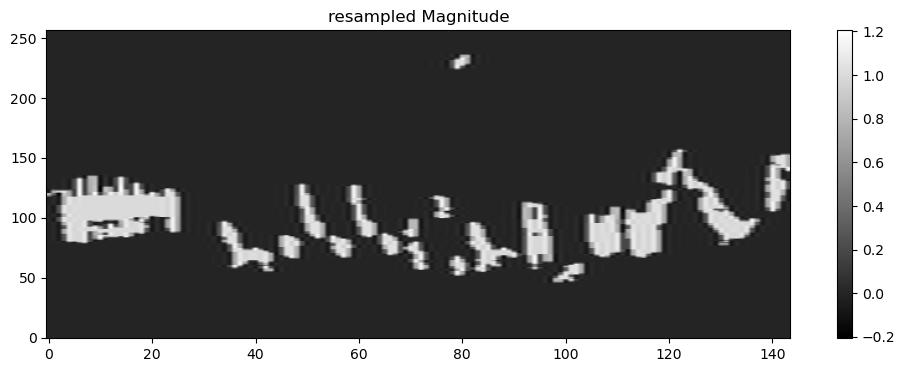

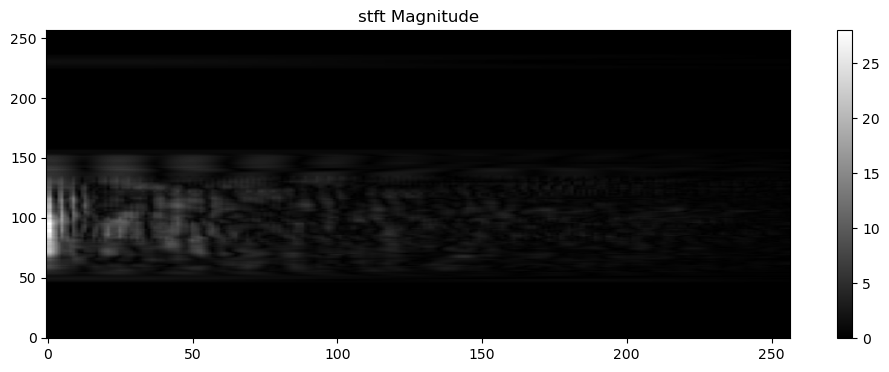

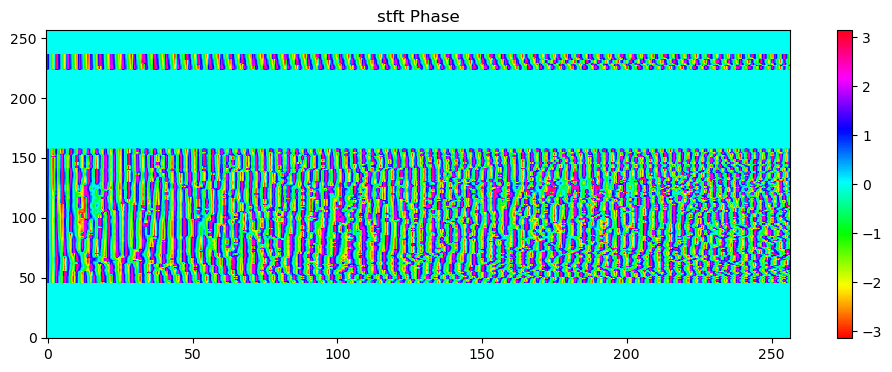

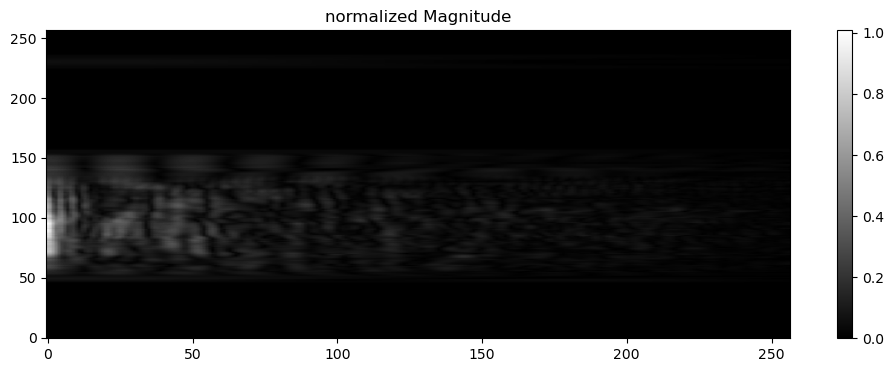

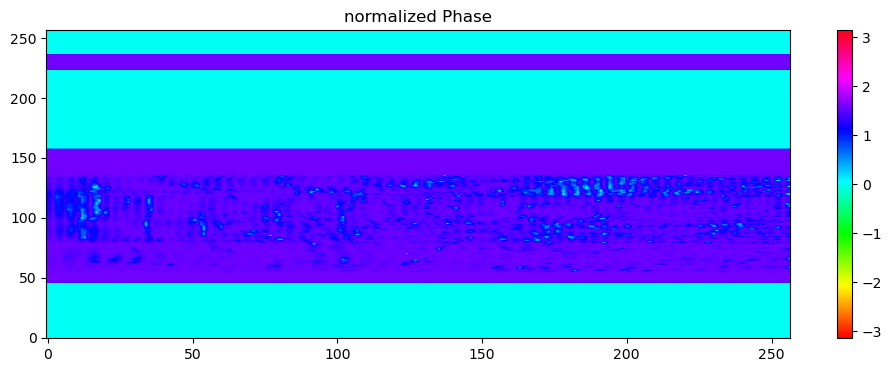

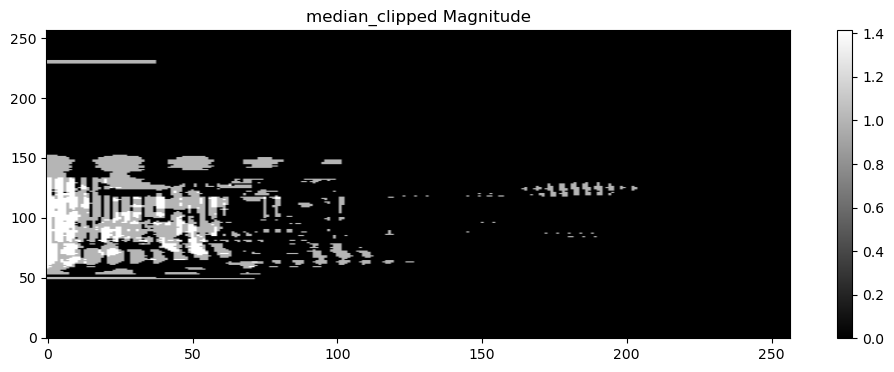

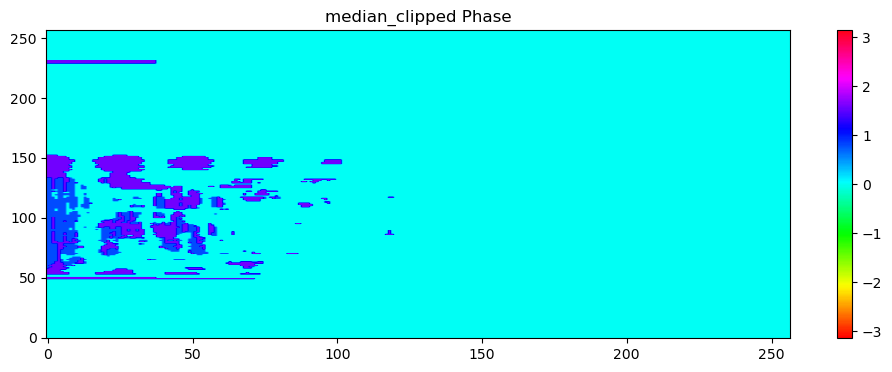

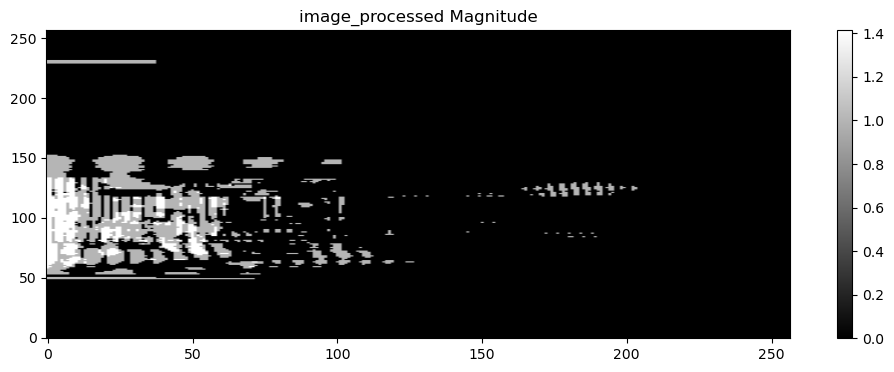

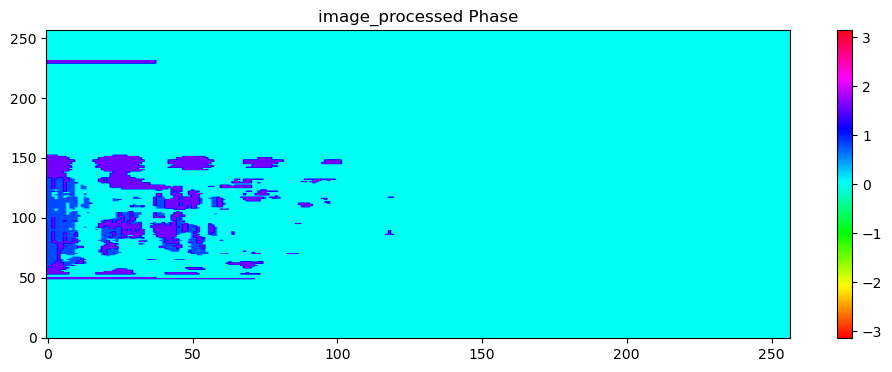

In [107]:
audio_transform = AudioPreprocessing()

sample, _ = train_dataset[0]  # Get the first sample from the dataset
waveform_tensor = sample[0]
processed_sample, intermediates = audio_transform(waveform_tensor)
visualize_intermediates(intermediates)  # Visualize the intermediate results

In [ ]:
# Calculate the global max length of waveforms in the dataset
global_max_len = max(max(wf.shape[2] for wf, _ in dataset) for dataset in [train_dataset, valid_dataset])

def collate_fn(batch):
    # A batch is a list of (waveform, target) pairs
    waveforms, targets = zip(*batch)

    # Pad the waveforms to the global max length
    waveforms = [torch.cat([wf, torch.zeros((1, wf.shape[1], global_max_len - wf.shape[2]))], dim=2) for wf in waveforms]

    waveforms = torch.stack(waveforms)
    targets = torch.stack(targets)

    return waveforms, targets

# Update DataLoader objects with the new collate_fn
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 32 * 36, 128),  # Adjusted for the added MaxPool
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

# Initialize the model
model = ImprovedCNN(num_classes=len(class_names)).to(device)


Using: cuda


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

# Loss and Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Basic loss for multilabel.

# Setting up the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 5
early_stop = False

num_epochs = 40
for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)

    # Validation
    model.eval()
    running_val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            # Store predictions and true labels
            all_preds.extend(outputs.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    val_loss = running_val_loss / len(valid_loader)

    # Find the best threshold for F1 score
    thresholds = np.arange(0.05, 1.0, 0.05)
    f1_scores = []
    for threshold in thresholds:
        f1_scores.append(f1_score(all_labels, np.array(all_preds) > threshold, average='samples'))

    # Get the best F1 score and corresponding threshold
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    best_f1 = f1_scores[best_threshold_index]

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Best Validation F1: {best_f1:.4f} at threshold {best_threshold:.2f}")

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        early_stop = True
        break

    # Adjusting learning rate
    scheduler.step(val_loss)

if early_stop:
    print("Stopped training. Loading best model weights!")
    model.load_state_dict(torch.load('best_model.pth'))

print('Finished Training')

Epoch 1, Train Loss: 0.0928, Validation Loss: 0.0471, Best Validation F1: 0.4246 at threshold 0.10
Epoch 2, Train Loss: 0.0777, Validation Loss: 0.0460, Best Validation F1: 0.4434 at threshold 0.10
Epoch 3, Train Loss: 0.0729, Validation Loss: 0.0424, Best Validation F1: 0.4812 at threshold 0.15
Epoch 4, Train Loss: 0.0687, Validation Loss: 0.0425, Best Validation F1: 0.4798 at threshold 0.10
Epoch 5, Train Loss: 0.0686, Validation Loss: 0.0446, Best Validation F1: 0.4967 at threshold 0.10
Epoch 6, Train Loss: 0.0633, Validation Loss: 0.0413, Best Validation F1: 0.5222 at threshold 0.15
Epoch 7, Train Loss: 0.0612, Validation Loss: 0.0432, Best Validation F1: 0.5062 at threshold 0.10
Epoch 8, Train Loss: 0.0582, Validation Loss: 0.0443, Best Validation F1: 0.5196 at threshold 0.15
Epoch 9, Train Loss: 0.0581, Validation Loss: 0.0427, Best Validation F1: 0.5333 at threshold 0.15
Epoch 10, Train Loss: 0.0576, Validation Loss: 0.0439, Best Validation F1: 0.5399 at threshold 0.15
Epoch 11,

In [ ]:
print(f"Best threshold: {best_threshold}")

Best threshold: 0.15000000000000002


In [ ]:
from sklearn.metrics import f1_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.20).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1_macro = f1_score(all_labels, all_preds, average='samples')
print(f"F1 Score (Samples): {f1_macro}")


F1 Score (Samples): 0.47448386762112255


In [ ]:
def test_collate_fn(batch):
    # A batch is a list of (waveform, filename) pairs for the test dataset
    waveforms, filenames = zip(*batch)

    # Pad the waveforms to the global max length
    waveforms = [torch.cat([wf, torch.zeros((1, wf.shape[1], global_max_len - wf.shape[2]))], dim=2) for wf in waveforms]

    waveforms = torch.stack(waveforms)

    return waveforms, filenames


# Loading the test set
class BirdSongTestDataset(Dataset):
    def __init__(self, df, audio_dir, transform=None):
        self.df = df
        self.audio_dir = audio_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx, 0]
        audio_path = os.path.join(self.audio_dir, filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, filename

test_csv = pd.read_csv('data/test.csv')
test_dataset = BirdSongTestDataset(test_csv, 'data/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=test_collate_fn)

# Make predictions on test set
model.eval()
predictions = {}
with torch.no_grad():
    for inputs, filenames in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (outputs > best_threshold).float().cpu().numpy().astype(int)  # Convert to int after thresholding
        for fname, pred in zip(filenames, preds):
            predictions[fname] = pred  # pred is now an int array

# Convert predictions to submission format
submission_df = pd.DataFrame.from_dict(predictions, orient='index', columns=class_names)
submission_df.reset_index(inplace=True)
submission_df.rename(columns={'index': 'filename'}, inplace=True)
submission_df.to_csv('submission.csv', index=False)